# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

# Starbucks Capstone Challenge

### 1. Import Libraries

In [6]:
# Packages for data processing
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Packages for ML 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression

# Package for model storage
import pickle

UsageError: Line magic function `%` not found.


### 2. Loading Data
The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer
transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [7]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript.shape

(306534, 4)

### 3. Data Overview

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [8]:
# Overview of portfolio file
print(portfolio.info(),'\n')
print(portfolio.head(),'\n')
print('Shape of portfolio:',portfolio.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None 

   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id 

In [9]:
print(profile.info(),'\n')
print(profile.head(),'\n')
print('Shape of profile:',profile.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None 

  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN 

Shape of profile: (17000, 5)


In [10]:
print(transcript.info(),'\n')
print(transcript.head(),'\n')
print('Shape of transcipt:',transcript.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None 

                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb46111

### 4. Data Cleaning
    a) Cleaning of portfolio file

In [11]:
# Start with Portfolio file
# Channel column can be seperated into various labels
portfolio['channels'].values

array([list(['email', 'mobile', 'social']),
       list(['web', 'email', 'mobile', 'social']),
       list(['web', 'email', 'mobile']), list(['web', 'email', 'mobile']),
       list(['web', 'email']), list(['web', 'email', 'mobile', 'social']),
       list(['web', 'email', 'mobile', 'social']),
       list(['email', 'mobile', 'social']),
       list(['web', 'email', 'mobile', 'social']),
       list(['web', 'email', 'mobile'])], dtype=object)

In [12]:
channels_type = ['web', 'email', 'mobile', 'social']
for i in channels_type:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
# Remove the redundent columns (channels and id)
portfolio = portfolio.drop(['channels'],axis =1)
portfolio.head()

reward  difficulty  duration     offer_type  \
0      10          10         7           bogo   
1      10          10         5           bogo   
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   

                                 id  web  email  mobile  social  
0  ae264e3637204a6fb9bb56bc8210ddfd    0      1       1       1  
1  4d5c57ea9a6940dd891ad53e9dbe8da0    1      1       1       1  
2  3f207df678b143eea3cee63160fa8bed    1      1       1       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9    1      1       1       0  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7    1      1       0       0

    b) Cleaning of profile file

In [14]:
# Check for empty cells in the data cell
profile.isnull().sum()
income_mean = profile['income'].mean()
# Fill in the blank cell in Gender columns with str_'Unknown'
profile['gender'].fillna('Unknown', inplace = True)
# Fill in the income value with mean of the data_set
    ## There are two stragtegies here on is to implement the income with mean()
    ## Or simply drop the rows without income data
profile['income'].fillna(income_mean, inplace = True)
profile.describe()
# Double check if there is null cells
profile.isnull().sum()
profile.head()

gender  age                                id  became_member_on  \
0  Unknown  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
1        F   55  0610b486422d4921ae7d2bf64640c50b          20170715   
2  Unknown  118  38fe809add3b4fcf9315a9694bb96ff5          20180712   
3        F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509   
4  Unknown  118  a03223e636434f42ac4c3df47e8bac43          20170804   

          income  
0   65404.991568  
1  112000.000000  
2   65404.991568  
3  100000.000000  
4   65404.991568

#### It is interesting to find the the ages columns have over 2000 number of users with age 118, which does not make sense. I dicided to change those points with 0 to mark the missing value

54.39352445193929


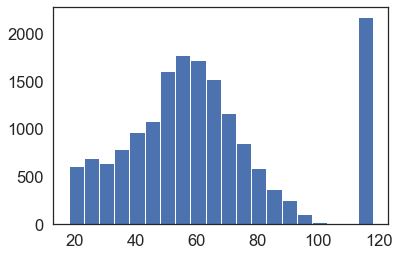

In [310]:
# It is interesting to find the the ages columns have large porportion with the 
Ages_list = list(profile['age'])
Age_mean = profile[profile['age']!=118].age.mean()
plt.hist(Ages_list, bins = 20)
print(Age_mean)
plt.show()

(array([2175.,    0.,    0.,  340.,  672.,  693.,  669.,  928., 1054.,
        1337., 1795., 1795., 1556., 1354.,  982.,  664.,  478.,  289.,
         171.,   48.]),
 array([  0.  ,   5.05,  10.1 ,  15.15,  20.2 ,  25.25,  30.3 ,  35.35,
         40.4 ,  45.45,  50.5 ,  55.55,  60.6 ,  65.65,  70.7 ,  75.75,
         80.8 ,  85.85,  90.9 ,  95.95, 101.  ]),
 <a list of 20 Patch objects>)

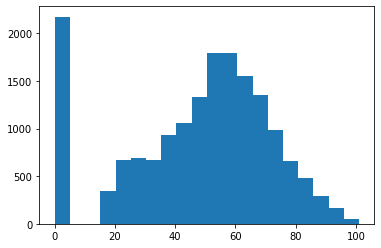

In [15]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile.age.replace(to_replace = {118:0},inplace = True)
#Check the age distribution again
plt.hist(profile.age, bins = 20)

    c) Cleaning of transcript file

In [16]:
#check if there is null items
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [17]:
# The transcript file have no missing elements
# The data is packed in a dictionary with the following items
value_list = ['offer id','amount','offer_id','reword']
# offer id and offer_id should be treated as equal

In [18]:
# The transcript file have no missing elements
# The data is packed in a dictionary with the following items
value_list = ['offer id','amount','offer_id','reword']
# offer id and offer_id should be treated as equal
# Create empty columns to extract date from 'value' column
transcript['amount'] = float(0)
transcript['reward'] = float(0)
transcript['offer id'] = ''
# Fill in the empty cells with data using match data type   
for i, j in transcript.iterrows():
    for item in j['value']:
        if item == 'amount':
            transcript.at[i, 'amount'] = float(j['value'][item])
        if item == 'reward':
            transcript.at[i, 'reward'] = float(j['value'][item])
        if item == 'offer_id' or item == 'offer id':
            transcript.at[i,'offer id']= j['value'][item]         
# Drop the 'value' column
study_tran = transcript.drop('value',axis = 1)

In [19]:
study_tran = transcript.copy()
study_tran.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  amount  reward  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0     0.0     0.0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0     0.0     0.0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0     0.0     0.0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0     0.0     0.0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0     0.0     0.0   

                           offer id  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7  
2  2906b810c7d4411798c6938adc9daaa5  
3  fafdcd668e3743c1bb461111dcafc2a4  
4  4d5c57ea9a6940dd891ad53e9dbe8da0

### 5. Data Analysis

### Reserch into user age
1) what is the mean of the user age

2) what is the distribution of user age

3) what is the user age distribution with different gender

4) what is the user distribution with different age group

In [319]:
#1) Mean of the user age
profile.age.mean()

47.43435294117647

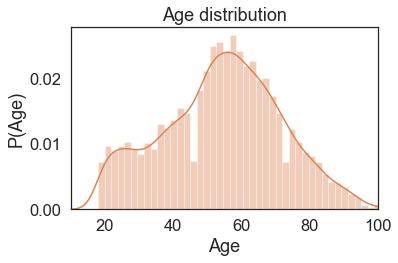

In [320]:
#2) Distribution of user age
# Remove the unrealistic data point 
x1 = profile[profile['age'] !=0].age
# Plot the Age distribution of the starbuck user
current_palette = sns.color_palette()
sns.set(font_scale=1.5)
sns.set_style('white')
sns.distplot(x1,color=current_palette[1])
plt.xlabel('Age')
plt.xlim(10, 100)
plt.ylabel('P(Age)')
plt.title('Age distribution')
plt.tight_layout()

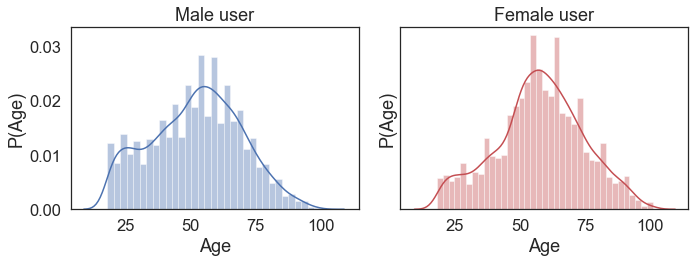

In [321]:
# 3) Age distribution with different gender
study_age_gender = profile[profile['age'] !=0]
x1 = study_age_gender[study_age_gender['gender'] == 'M'].age
x2 = study_age_gender[study_age_gender['gender'] == 'F'].age

#Plot the user data in a 
current_palette = sns.color_palette()
sns.set(font_scale=1.5)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(x1,
             color=current_palette[0])
plt.xlabel('Age')
plt.ylabel('P(Age)')
plt.title('Male user')

plt.sca(ax[1])
sns.distplot(x2,
             color=current_palette[3])
plt.xlabel('Age')
plt.ylabel('P(Age)')
plt.title('Female user')
plt.tight_layout()

The age distribution of Male users and female distinct with each other. In this way, it could be better to distribute those users into different groups.

Young adults: <25;
Adults: >=25 while <=35
Middle age: >=35 while <=45
Elder adults: >45 while <=55
Elderly: >55;

In [322]:
# 4) The user distribution with different age group
Age_basket = ['Young adults','Adults','Middle age','Elder adults','Elderly']
def age_basket (age_list):
    y = a = m = e = o = 0
    for i in age_list:
        if i < 25:
            y += 1
        if i >= 25 and i <35:
            a += 1
        if i >= 35 and i < 45:
            m += 1
        if i >= 45 and i< 55:
            e += 1
        if i >= 55:
            o +=1
    return [y,a,m,e,o]
x1 = age_basket(list(study_age_gender[study_age_gender['gender'] == 'M'].age))
x2 = age_basket(list(study_age_gender[study_age_gender['gender'] == 'F'].age))

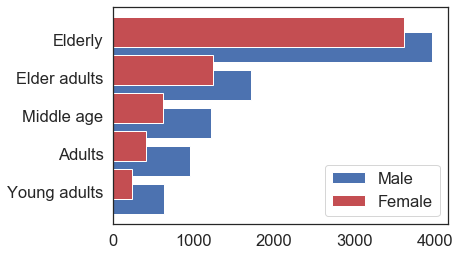

In [323]:
ypos = np.arange(len(Age_basket))
current_palette = sns.color_palette()
plt.yticks(ypos,Age_basket)
plt.barh(ypos-0.2,x1,label = 'Male',color = current_palette[0])
plt.barh(ypos+0.2,x2,label = 'Female',color = current_palette[3])
plt.legend()

### Research into user salary
1) What is the mean of user salery

2) What is the salery distribution of the users with different gender


In [382]:
# 1) What is the mean of user salery
profile.income.dropna().mean()

65404.9915682968

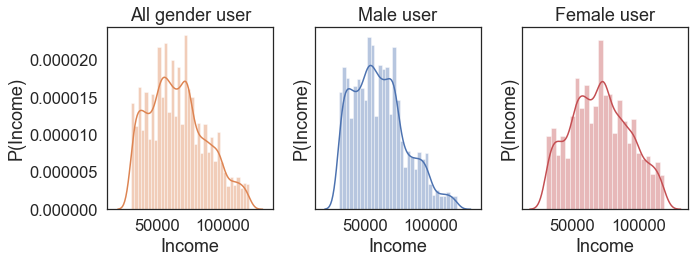

In [324]:
# 2) Salery distribution
profile['income']
profile['income'].dropna()
x1 = profile['income']
x2 = profile[profile['gender']=='M'].income.dropna()
x3 = profile[profile['gender']=='F'].income.dropna()
# Plot the Age distribution of the starbuck user

current_palette = sns.color_palette()
sns.set(font_scale=1.5)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=3,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(x1,
             color=current_palette[1])
plt.xlabel('Income')
plt.ylabel('P(Income)')
plt.title('All gender user')

plt.sca(ax[1])
sns.distplot(x2,
             color=current_palette[0])
plt.xlabel('Income')
plt.ylabel('P(Income)')
plt.title('Male user')

plt.sca(ax[2])
sns.distplot(x3,
             color=current_palette[3])

plt.xlabel('Income')
plt.ylabel('P(Income)')
plt.title('Female user')
plt.tight_layout()

### Research into promote method

1) What is the distribution of successful promote method

2) What is the distribution of promote type

3) What is the usage of the promote method

4) What is the accumulate usage of promote method with different gender

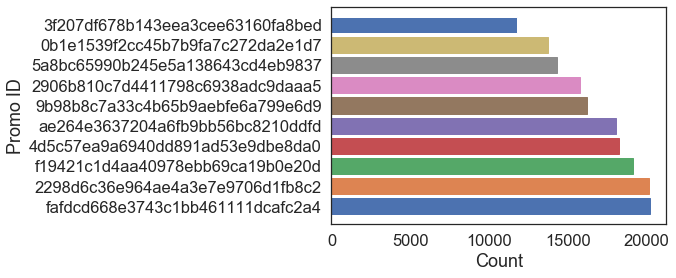

In [325]:
# 1) What is the distribution of successful promote method
# calculate the number of promo code usage
promo_id = list(transcript['offer id'].value_counts().index)
promo_id.pop(0)
promo_count = list(transcript['offer id'].value_counts())
promo_count.pop(0)
ypos = np.arange(len(promo_count))
current_palette = sns.color_palette()
plt.yticks(ypos,promo_id)
plt.xlabel('Count')
plt.ylabel('Promo ID')
a = plt.barh(ypos,promo_count)
for i in range(len(promo_id)-1):
    a[i].set_color(current_palette[i])

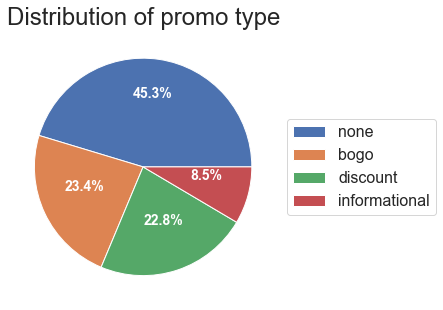

In [326]:
# 2) What is the distribution of promote type
study_promotype = study_tran
study_promotype['offer id'].replace(to_replace = {'ae264e3637204a6fb9bb56bc8210ddfd':'bogo','4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo','9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo','3f207df678b143eea3cee63160fa8bed':'informational','0b1e1539f2cc45b7b9fa7c272da2e1d7':'discount','2298d6c36e964ae4a3e7e9706d1fb8c2':'discount','fafdcd668e3743c1bb461111dcafc2a4':'discount','5a8bc65990b245e5a138643cd4eb9837':'informational','f19421c1d4aa40978ebb69ca19b0e20d':'bogo','2906b810c7d4411798c6938adc9daaa5':'discount','':'none'},inplace = True)
promo_val = list(study_promotype['offer id'].value_counts())
promo_type = list(study_promotype['offer id'].value_counts().index)

# Plot the data in a pie chart
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
data = promo_val
ingredients = promo_type


def func(pct, allvals):
    if pct/100.*np.sum(allvals)>0.01:
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n".format(pct, absolute)
    else:
        return None


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          loc="center left",
          fontsize = 16,
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=14, weight="bold")

ax.set_title("Distribution of promo type",fontsize=24, loc = 'left')

plt.show()


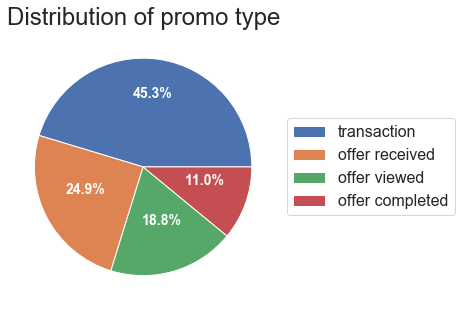

In [327]:
# 3) What is the usage of the promote method
study_tran.event.value_counts()
promo_val = list(study_tran.event.value_counts())
promo_type = list(study_tran.event.value_counts().index)

# Plot the data in a pie chart
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
data = promo_val
ingredients = promo_type


def func(pct, allvals):
    if pct/100.*np.sum(allvals)>0.01:
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n".format(pct, absolute)
    else:
        return None


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          loc="center left",
          fontsize = 16,
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=14, weight="bold")

ax.set_title("Distribution of promo type",fontsize=24, loc = 'left')

plt.show()


In [328]:
# 4) What is the accumulate usage of promote method with different gender
promo_val_male = list(study_tran.event.value_counts())
promo_type_male = list(study_tran.event.value_counts().index)

### Reserch into users transcript

1) What is the mean time of purchase for users

2) What is the frequency distribution of users

In [335]:
study_tran.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  amount  reward  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0     0.0     0.0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0     0.0     0.0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0     0.0     0.0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0     0.0     0.0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0     0.0     0.0   

   offer id  
0      bogo  
1  discount  
2  discount  
3  discount  
4      bogo

In [351]:
# 1） what is the mean time of purchase for users
study_tran['person'].value_counts().mean()

18.031411764705883

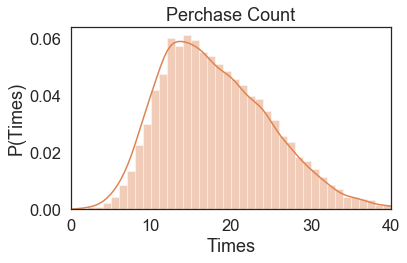

In [22]:
# 2) What is the frequency distribution of users
x1= list(study_tran['person'].value_counts())
# Plot the Age distribution of the starbuck user
current_palette = sns.color_palette()
sns.set(font_scale=1.5)
sns.set_style('white')
sns.distplot(x1,color=current_palette[1])
plt.xlabel('Times')
plt.xlim(0, 40)
plt.ylabel('P(Times)')
plt.title('Perchase Count')
plt.tight_layout()

### 6. Machine learning model
Machine learning models was built to predict whether a specific user would actually use a pomote code while receiving a specific one

Possible variable that could possiblily effect the decision making of whether to use the promo method are:
    1. Age of the user
    2. Gender of the user
    3. Time of the discount last
    4. Amount of the rewards
    5. Income of the user
    6. Difficulty
    7. Duration
    8. offer_type
    9. Source of the discount
    
    
Three models was built with different training algorithm
        
1. Logistic regression
2. Naive Bayes
3. Support Vector Machine

### Dataset preparation

In [377]:
# Resorces of processed data frame
# The portfolio of the promote code: portfolio
# Processed info of the users: profile
# The process of transcript info : study_tran

In [401]:
profile.head()
portfolio.head()
study_tran = transcript.copy()

In [402]:
# Before training model we merge the useful data into one dataframe
portfolio.rename(columns={'id':'offer_id'},inplace=True) 
study_tran.rename(columns={'person':'user_id', 'offer id':'offer_id','reward':'user_reward'},
                  inplace=True) 
profile.rename(columns={'id':'user_id'},inplace=True) # one-time code
part=pd.merge(study_tran,profile,how='left',on=['user_id']) 
merged=pd.merge(part,portfolio,how='left',on=['offer_id'])
merged.drop('became_member_on',axis = 1,inplace = True)

In [403]:
study_model = merged.copy()
study_model.drop('user_id',axis = 1, inplace = True)
study_model.drop('value',axis = 1, inplace = True)
study_model.drop('offer_id',axis = 1, inplace = True)
study_model.head()

event  time  amount  user_reward gender  age    income  reward  \
0  offer received     0     0.0          0.0      F   75  100000.0     5.0   
1  offer received     0     0.0          0.0   None    0       NaN     5.0   
2  offer received     0     0.0          0.0      M   68   70000.0     2.0   
3  offer received     0     0.0          0.0   None    0       NaN     2.0   
4  offer received     0     0.0          0.0   None    0       NaN    10.0   

   difficulty  duration offer_type  web  email  mobile  social  
0         5.0       7.0       bogo  1.0    1.0     1.0     0.0  
1        20.0      10.0   discount  1.0    1.0     0.0     0.0  
2        10.0       7.0   discount  1.0    1.0     1.0     0.0  
3        10.0      10.0   discount  1.0    1.0     1.0     1.0  
4        10.0       5.0       bogo  1.0    1.0     1.0     1.0

In [404]:
study_model.income.fillna(65404,inplace = True)
study_model.gender.fillna('N',inplace = True)

In [405]:
study_model.head()

event  time  amount  user_reward gender  age    income  reward  \
0  offer received     0     0.0          0.0      F   75  100000.0     5.0   
1  offer received     0     0.0          0.0      N    0   65404.0     5.0   
2  offer received     0     0.0          0.0      M   68   70000.0     2.0   
3  offer received     0     0.0          0.0      N    0   65404.0     2.0   
4  offer received     0     0.0          0.0      N    0   65404.0    10.0   

   difficulty  duration offer_type  web  email  mobile  social  
0         5.0       7.0       bogo  1.0    1.0     1.0     0.0  
1        20.0      10.0   discount  1.0    1.0     0.0     0.0  
2        10.0       7.0   discount  1.0    1.0     1.0     0.0  
3        10.0      10.0   discount  1.0    1.0     1.0     1.0  
4        10.0       5.0       bogo  1.0    1.0     1.0     1.0

In [406]:
# Map gender and promo type into numbers 
# Map gender F to '1' and M to '2'
study_model.gender.replace(to_replace = {'F':1,'M':2,'O':3,'N':0},inplace = True)
# Map event offer received to '1' and offer viewed to '2' 'offer completed' to '3'
study_model.event.replace(to_replace = {'offer received':0,'offer viewed':1,'offer completed':2},inplace = True)
# Map event bogo to '1' and discount to '2' 'informational' to 3
study_model.offer_type.replace(to_replace = {'bogo':1,'discount':2,'informational':3},inplace = True)

In [411]:
feature = study_model.copy()
feature = feature[feature['event']!='transaction']

In [462]:
#Check the data set used for machine learning
target = list(feature.event)

list

In [465]:
feature_mod.head()

time  amount  user_reward  gender  age    income  reward  difficulty  \
0     0     0.0          0.0       1   75  100000.0     5.0         5.0   
1     0     0.0          0.0       0   47   65404.0     5.0        20.0   
2     0     0.0          0.0       2   68   70000.0     2.0        10.0   
3     0     0.0          0.0       0   47   65404.0     2.0        10.0   
4     0     0.0          0.0       0   47   65404.0    10.0        10.0   

   duration  offer_type  web  email  mobile  social  
0       7.0         1.0  1.0    1.0     1.0     0.0  
1      10.0         2.0  1.0    1.0     0.0     0.0  
2       7.0         2.0  1.0    1.0     1.0     0.0  
3      10.0         2.0  1.0    1.0     1.0     1.0  
4       5.0         1.0  1.0    1.0     1.0     1.0

In [478]:
feature_mod = feature.copy()
feature_mod.drop('event',axis=1,inplace = True)
# Fix the problem when age is 0, and replace it with the mean of age of users
feature_mod.age.replace(to_replace = {0:47},inplace = True)
feature_mod.astype(float)

time  amount  user_reward  gender   age    income  reward  \
0         0.0     0.0          0.0     1.0  75.0  100000.0     5.0   
1         0.0     0.0          0.0     0.0  47.0   65404.0     5.0   
2         0.0     0.0          0.0     2.0  68.0   70000.0     2.0   
3         0.0     0.0          0.0     0.0  47.0   65404.0     2.0   
4         0.0     0.0          0.0     0.0  47.0   65404.0    10.0   
...       ...     ...          ...     ...   ...       ...     ...   
306497  714.0     0.0          3.0     0.0  47.0   65404.0     3.0   
306506  714.0     0.0          2.0     0.0  47.0   65404.0     2.0   
306507  714.0     0.0          0.0     1.0  60.0   64000.0     5.0   
306509  714.0     0.0          2.0     2.0  39.0   39000.0     2.0   
306527  714.0     0.0          2.0     1.0  48.0   80000.0     2.0   

        difficulty  duration  offer_type  web  email  mobile  social  
0              5.0       7.0         1.0  1.0    1.0     1.0     0.0  
1             20.0      10.0         2.0  1.0    1.0     0.0     0.0  
2             10.0       7.0         2.0  1.0    1.0     1.0     0.0  
3             10.0      10.0         2.0  1.0    1.0     1.0     1.0  
4             10.0       5.0         1.0  1.0    1.0     1.0     1.0  
...            ...       ...         ...  ...    ...     ...     ...  
306497         7.0       7.0         2.0  1.0    1.0     1.0     1.0  
306506        10.0      10.0         2.0  1.0    1.0     1.0     1.0  
306507        20.0      10.0         2.0  1.0    1.0     0.0     0.0  
306509        10.0      10.0         2.0  1.0    1.0     1.0     1.0  
306527        10.0      10.0         2.0  1.0    1.0     1.0     1.0  

[167581 rows x 14 columns]

### Model construction

In [479]:
# Resources for training and prediction
# target ---- the reaction for users which receiving a promote code
# feature_mod ---- resources to predict the target

In [480]:
# Seperate the data into traing and test part
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(feature_mod, target,test_size = 0.33, random_state=0)

In [481]:
# Build functions to evaluate the model
def evaluate_model(model,X_test, y_test):
    '''
    Evaluation report of the model, and print the F1 scores
    INPUT: model, x_test and y_test
    OUPUT: evaluation report in text files 
    '''
    y_predict = model.predict(X_test)
    print(classification_report(y_test, y_predict))

#### Model 1 - Logistic Regression

In [482]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
evaluate_model(logreg,X_test, y_test)

              precision    recall  f1-score   support

           0       0.48      0.74      0.58     25354
           1       0.39      0.25      0.30     18854
           2       0.47      0.19      0.27     11094

    accuracy                           0.46     55302
   macro avg       0.45      0.39      0.38     55302
weighted avg       0.45      0.46      0.42     55302



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [492]:
with open('Logistic_regression_model.pkl', 'wb') as f1:
    pickle.dump(logreg, f1)

#### Model 2 - Naive Bayes

In [486]:
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
evaluate_model(gnb,X_test, y_test)

              precision    recall  f1-score   support

           0       0.61      0.68      0.64     25354
           1       0.49      0.41      0.44     18854
           2       1.00      1.00      1.00     11094

    accuracy                           0.65     55302
   macro avg       0.70      0.70      0.70     55302
weighted avg       0.65      0.65      0.65     55302



In [495]:
with open('Naive_Bayes_model_first.pkl', 'wb') as f2:
    pickle.dump(gnb, f2)

#### Model 3 - Suport Vector Machine

In [487]:
svm = SVC()
svm.fit(X_train, y_train)
evaluate_model(svm,X_test, y_test)

              precision    recall  f1-score   support

           0       0.46      1.00      0.63     25354
           1       0.00      0.00      0.00     18854
           2       0.00      0.00      0.00     11094

    accuracy                           0.46     55302
   macro avg       0.15      0.33      0.21     55302
weighted avg       0.21      0.46      0.29     55302



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [496]:
with open('Suport Vector Machine.pkl', 'wb') as f3:
    pickle.dump(svm, f3)